# 0. Importing and Setting up

In [ ]:
# Import Pytorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Visualization
import matplotlib.pyplot as plt

torch.__version__
import torch

In [ ]:
# Set up device agnostice code
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [ ]:
!nvidia-smi

Mon Jun 10 13:51:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


# 1. Get the dataset

In [ ]:
# Setup training data
train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

# 2. Data Preparation and Data Exploration

In [ ]:
len(train_data)

60000

In [ ]:
# Dictionary of class names
class_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}


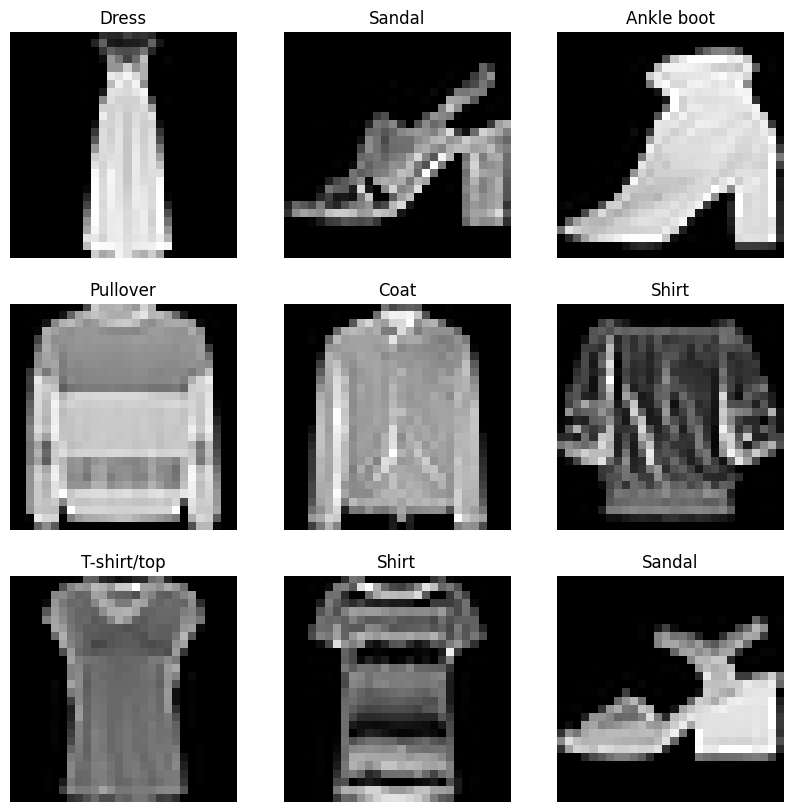

In [ ]:
cols, rows = 3, 3
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 10))

for i in range(rows * cols):
    idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[idx]
    img = img.squeeze().numpy()  # Convert to numpy array if it's a PyTorch tensor

    ax[i // cols, i % cols].imshow(img, cmap="gray")  # Display the image
    ax[i // cols, i % cols].set_title(class_names[label])  # Set the title
    ax[i // cols, i % cols].axis(False)  # Turn off axis

plt.show()

# 3. Turn loaded images into DataLoaders

In [ ]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 64

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x7edef7a065f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7edef7a06dd0>)

In [ ]:
len(train_data.classes)

10

In [ ]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([64, 1, 28, 28])
Label shape: torch.Size([64])


# 4. Model 1: LeNet-5

In [ ]:
class FashionMNIST_LeNet5(nn.Module):
  def __init__(self, num_classes: int):
    super().__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.fc = nn.Linear(in_features=400, out_features=120) # fully connected layer
    self.bn1 = nn.BatchNorm1d(120)  # Batch normalization after the first linear layer
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(in_features=120, out_features=84)
    self.bn2 = nn.BatchNorm1d(84)  # Batch normalization after the first linear layer
    self.relu2 = nn.ReLU()
    self.fc3 = nn.Linear(in_features=84, out_features=num_classes)
    self.fc4 = nn.Softmax(dim=1)# Define proportion or neurons to dropout



  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.shape[0], -1) # flatten into single dimension
    out = self.fc(out)
    out = self.relu(self.bn1(out))
    out = self.fc2(out)
    out = self.relu2(self.bn2(out))
    out = self.fc3(out)
    out = self.fc4(out)

    return out


## 4.1 Set up loss function and optimizer

In [ ]:
model_1 = FashionMNIST_LeNet5(num_classes=10)

# Set up loss function
loss_fn = nn.CrossEntropyLoss()

# Set up optimizer
learning_rate = 0.01
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=learning_rate)

## 4.2 Model summary

In [ ]:
# Instll torchinfo, import if its available
try:
  import torchinfo
  print("torchinfo available")
except:
  !pip install torchinfo
  import torchinfo
  print("torchinfo not available, installing")

torchinfo available


In [ ]:
import torchinfo
from torchinfo import summary

summary(model=model_1, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FashionMNIST_LeNet5                      [1, 10]                   --
├─Sequential: 1-1                        [1, 6, 13, 13]            --
│    └─Conv2d: 2-1                       [1, 6, 26, 26]            156
│    └─ReLU: 2-2                         [1, 6, 26, 26]            --
│    └─MaxPool2d: 2-3                    [1, 6, 13, 13]            --
├─Sequential: 1-2                        [1, 16, 5, 5]             --
│    └─Conv2d: 2-4                       [1, 16, 11, 11]           2,416
│    └─ReLU: 2-5                         [1, 16, 11, 11]           --
│    └─MaxPool2d: 2-6                    [1, 16, 5, 5]             --
├─Linear: 1-3                            [1, 120]                  48,120
├─BatchNorm1d: 1-4                       [1, 120]                  240
├─ReLU: 1-5                              [1, 120]                  --
├─Linear: 1-6                            [1, 84]                   10,164
├─

## 4.3 Helper functions

In [ ]:
# Download helper funcs from Learn PyTorch repo
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as file: # create and open a file to write helper functions to that file
    file.write(request.content)

helper_functions.py already exists, skipping download...


In [ ]:
from helper_functions import accuracy_fn, plot_loss_curves

## 5. Create train and test loops fucntion

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y).item()
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        return test_loss, test_acc

## 5.2 Create timer

In [ ]:

from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference btw start and end time"""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

## 5.3 Combine everything into a train function

In [ ]:
from tqdm import tqdm

In [ ]:
# Combine
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          accuracy_fn,
          epochs: int,
          device: torch.device = device):

  # Create an empty result dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(1, epochs + 1)):
    print(f"Epoch: {epoch}\n-------------")
    train_loss, train_acc = train_step(model=model,
                                        data_loader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        accuracy_fn=accuracy_fn,
                                        device=device)
    test_loss, test_acc = test_step(model=model,
                                    data_loader=test_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn,
                                    device=device)
    # 4. Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled result at the end of the epochs
  return results

In [ ]:
# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# Train model
epochs = 20
model_1_results = train(model=model_1,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      accuracy_fn=accuracy_fn,
                      epochs=epochs)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                              end=train_time_end_on_gpu,
                                              device=device)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1
-------------


  5%|▌         | 1/20 [00:23<07:18, 23.09s/it]


Train loss: 1.94940 | Train accuracy: 61.96% | Test loss: 1.79577 | Test accuracy: 74.43%

Epoch: 2
-------------


 10%|█         | 2/20 [00:35<04:59, 16.63s/it]


Train loss: 1.68727 | Train accuracy: 78.28% | Test loss: 1.69078 | Test accuracy: 77.62%

Epoch: 3
-------------


 15%|█▌        | 3/20 [00:47<04:06, 14.51s/it]


Train loss: 1.64544 | Train accuracy: 81.96% | Test loss: 1.64268 | Test accuracy: 82.07%

Epoch: 4
-------------


 20%|██        | 4/20 [00:59<03:38, 13.66s/it]


Train loss: 1.62559 | Train accuracy: 83.86% | Test loss: 1.62933 | Test accuracy: 83.40%

Epoch: 5
-------------


 25%|██▌       | 5/20 [01:11<03:17, 13.16s/it]


Train loss: 1.61483 | Train accuracy: 84.81% | Test loss: 1.61697 | Test accuracy: 84.53%

Epoch: 6
-------------


 30%|███       | 6/20 [01:23<02:59, 12.80s/it]


Train loss: 1.60718 | Train accuracy: 85.60% | Test loss: 1.60798 | Test accuracy: 85.33%

Epoch: 7
-------------


 35%|███▌      | 7/20 [01:36<02:44, 12.65s/it]


Train loss: 1.60043 | Train accuracy: 86.26% | Test loss: 1.60719 | Test accuracy: 85.38%

Epoch: 8
-------------


 40%|████      | 8/20 [01:50<02:36, 13.02s/it]


Train loss: 1.59494 | Train accuracy: 86.79% | Test loss: 1.60874 | Test accuracy: 85.46%

Epoch: 9
-------------


 45%|████▌     | 9/20 [02:02<02:21, 12.82s/it]


Train loss: 1.59042 | Train accuracy: 87.23% | Test loss: 1.60226 | Test accuracy: 85.97%

Epoch: 10
-------------


 50%|█████     | 10/20 [02:14<02:06, 12.65s/it]


Train loss: 1.58715 | Train accuracy: 87.53% | Test loss: 1.59702 | Test accuracy: 86.46%

Epoch: 11
-------------


 55%|█████▌    | 11/20 [02:26<01:52, 12.48s/it]


Train loss: 1.58451 | Train accuracy: 87.81% | Test loss: 1.58887 | Test accuracy: 87.20%

Epoch: 12
-------------


 60%|██████    | 12/20 [02:38<01:38, 12.37s/it]


Train loss: 1.58126 | Train accuracy: 88.09% | Test loss: 1.58916 | Test accuracy: 87.40%

Epoch: 13
-------------


 65%|██████▌   | 13/20 [02:51<01:26, 12.29s/it]


Train loss: 1.57787 | Train accuracy: 88.47% | Test loss: 1.59014 | Test accuracy: 87.24%

Epoch: 14
-------------


 70%|███████   | 14/20 [03:03<01:13, 12.27s/it]


Train loss: 1.57646 | Train accuracy: 88.53% | Test loss: 1.59107 | Test accuracy: 87.13%

Epoch: 15
-------------


 75%|███████▌  | 15/20 [03:15<01:00, 12.19s/it]


Train loss: 1.57405 | Train accuracy: 88.74% | Test loss: 1.58588 | Test accuracy: 87.71%

Epoch: 16
-------------


 80%|████████  | 16/20 [03:25<00:46, 11.73s/it]


Train loss: 1.57105 | Train accuracy: 89.13% | Test loss: 1.58575 | Test accuracy: 87.64%

Epoch: 17
-------------


 85%|████████▌ | 17/20 [03:37<00:34, 11.64s/it]


Train loss: 1.56892 | Train accuracy: 89.31% | Test loss: 1.57970 | Test accuracy: 88.29%

Epoch: 18
-------------


 90%|█████████ | 18/20 [03:48<00:22, 11.49s/it]


Train loss: 1.56713 | Train accuracy: 89.47% | Test loss: 1.57883 | Test accuracy: 88.25%

Epoch: 19
-------------


 95%|█████████▌| 19/20 [04:00<00:11, 11.63s/it]


Train loss: 1.56571 | Train accuracy: 89.66% | Test loss: 1.57976 | Test accuracy: 88.17%

Epoch: 20
-------------


100%|██████████| 20/20 [04:12<00:00, 12.62s/it]


Train loss: 1.56381 | Train accuracy: 89.82% | Test loss: 1.57833 | Test accuracy: 88.31%

Train time on cuda: 252.438 seconds


# 6. Evaluate model

## 6.1 Use Precision, Recall and F1 to Evaluate

Because this is a multi-class classification problem, we need to calculate the metrics for each class

In [ ]:
model_1.eval()
y_true = []
y_pred = []

# Prediction of test dataset
for img, labels in test_dataloader:
  img, labels = img.to(device), labels.to(device)
  outputs = model_1(img)
  _, predicted = torch.max(outputs, dim=1)
  y_true.extend(labels.cpu().numpy())
  y_pred.extend(predicted.cpu().numpy())


# Convert lists to tensors for calculation
y_true_tensor = torch.tensor(y_true)
y_pred_tensor = torch.tensor(y_pred)


# Calculate precision, recall, and F1 score using PyTorch
num_classes = 10

### Initiate tensors
TP = torch.zeros(num_classes)
FP = torch.zeros(num_classes)
FN = torch.zeros(num_classes)

for c in range(num_classes):
  TP[c] = ((y_true_tensor == c) & (y_pred_tensor == c)).sum().item()  # True positives
  FP[c] = ((y_true_tensor != c) & (y_pred_tensor == c)).sum().item()  # False positives
  FN[c] = ((y_true_tensor ==c) & (y_pred_tensor != c)).sum().item()  # True positives

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)


In [ ]:
print(f'Precision tensor: {precision}')
print(f'Recall tensor: {recall}')
print(f'F1 Score tensor: {f1}')

Precision tensor: tensor([0.7890, 0.9898, 0.8025, 0.8743, 0.8084, 0.9865, 0.7252, 0.9192, 0.9603,
        0.9694])
Recall tensor: tensor([0.8900, 0.9700, 0.8250, 0.9040, 0.7850, 0.9470, 0.6150, 0.9790, 0.9670,
        0.9490])
F1 Score tensor: tensor([0.8365, 0.9798, 0.8136, 0.8889, 0.7966, 0.9663, 0.6656, 0.9482, 0.9636,
        0.9591])


In [ ]:
for i in range(num_classes):
  print(f'Class {class_names[i]}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, F1 Score = {f1[i]:.4f}')
  print()

Class T-shirt/top: Precision = 0.7890, Recall = 0.8900, F1 Score = 0.8365

Class Trouser: Precision = 0.9898, Recall = 0.9700, F1 Score = 0.9798

Class Pullover: Precision = 0.8025, Recall = 0.8250, F1 Score = 0.8136

Class Dress: Precision = 0.8743, Recall = 0.9040, F1 Score = 0.8889

Class Coat: Precision = 0.8084, Recall = 0.7850, F1 Score = 0.7966

Class Sandal: Precision = 0.9865, Recall = 0.9470, F1 Score = 0.9663

Class Shirt: Precision = 0.7252, Recall = 0.6150, F1 Score = 0.6656

Class Sneaker: Precision = 0.9192, Recall = 0.9790, F1 Score = 0.9482

Class Bag: Precision = 0.9603, Recall = 0.9670, F1 Score = 0.9636

Class Ankle boot: Precision = 0.9694, Recall = 0.9490, F1 Score = 0.9591



## 6.2 Plot loss curve

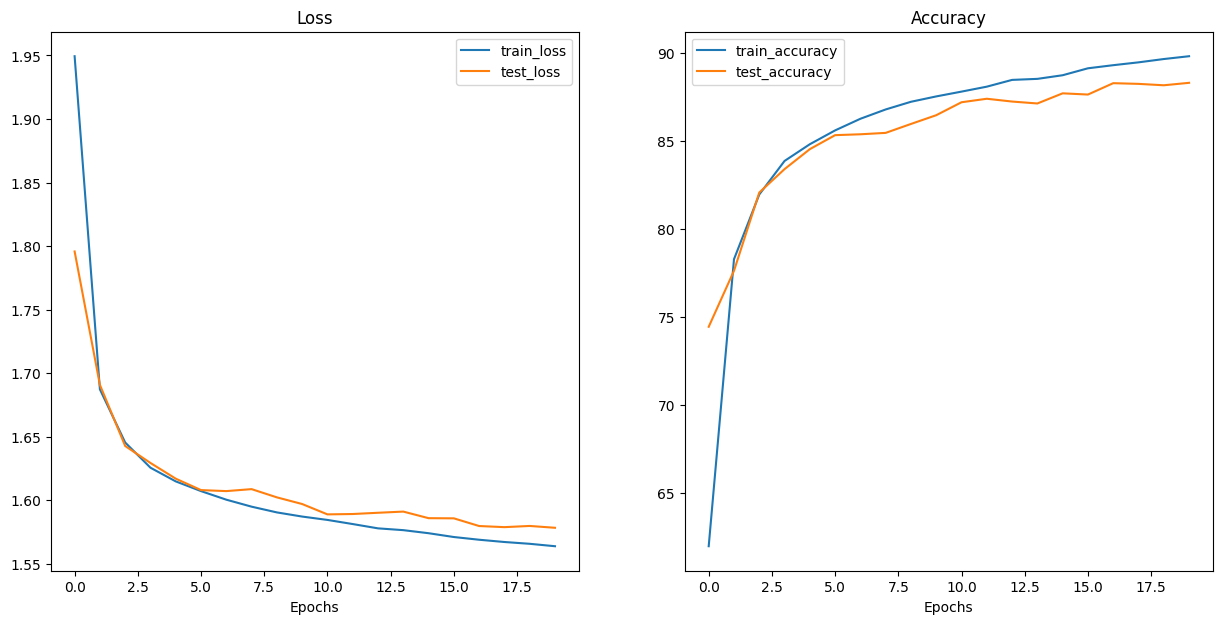

In [ ]:
plot_loss_curves(results=model_1_results)

## 6.3 Confusion Matrix

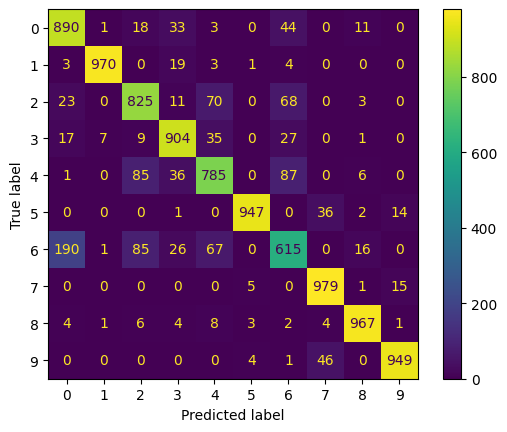

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()

# 7. Save model

In [ ]:
# Save the model state dictionary
torch.save(model_1.state_dict(), 'FMNIST_LeNet5.pth')
print("Model saved as FMNIST_LeNet5.pth")

Model saved as FMNIST_LeNet5.pth
